# Trivial Endpoints

This notebook can be used to reproduce the data analysis of the Appendix "Trivial Endpoints" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/data_analysis_appendix_trivial_endpoints.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [ ]:
!pip install re-technical-report

In [47]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import DataFrame
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

from re_technical_report import (
    re_data_by_name,
    rel_share_of_property,
    consistency_case_barplot,
    consistency_case_heatmaps_by_weights,
    plot_multiple_error_bars,
    heat_maps_by_weights,
    set_errorbar_plot_style,
    set_heatmap_plot_style,
    
    #TODO: uncomment
    
    #get_length, 
    #get_lengths,    
)

### Utility

In [56]:
# TODO: remove 

# working on strings directly in order to avoid having to literal_eval millions of strings

def get_length(pos):
    return len(pos.split(","))

def get_lengths(x, pos_type):
    
    # split the list of endpoint tuples 
    l = x.split('), (')

    # split each endpoint tuple into a theory and a commitment position (set representation with {})
    l = [s.split('}, {') for s in l]
    
    if not pos_type in ["theory", "commitments"]:
        raise ValueError("pos_type must be 'theory' or 'commitments'")
    
    idx = 0 if pos_type == "theory" else 1
     
    # length of the first (theory) or second (commitments) element  after 
    # the comma-separated sentences have been split
    return [len(s[idx].split(',')) for s in l]

## Loading data

In [48]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())

# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()

In [49]:
# TODO: remove
on_colab = True

In [50]:
# Columns relevant for this notebook.
usecols = ["model_name",
           "n_sentence_pool",
           "ds",
           "init_coms",
           "weight_account", 
           "weight_systematicity",
           "n_fixed_points",
           "n_global_optima",
           "error_code",
           "fixed_points",
           "global_optima",
           "fixed_point_coms",
           "fixed_point_theory",
          ]

In [51]:
# Columns that need to be evaluated literally

evalcols =["x"] # dummy column to circumvent literal evaluation

In [52]:
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="TINY", 
                          usecols = usecols,
                          evalcols = evalcols,
                          filter_erroneous_runs = True)

In [53]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 12637
   Number of dialectical structures: 2
   Overall number of initial commitments: 40
   Sentence-pools: [6 7]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [54]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                                                 "ds",
                                                 "n_sentence_pool",
                                                 "weight_account", 
                                                 "weight_systematicity", 
                                                 "init_coms"
                                                ])

re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       1440
LinearLocalRE        1440
QuadraticGlobalRE    1440
QuadraticLocalRE     1440
dtype: int64

In [55]:
#coolwarm = ['#6788ee', '#9abbff', '#e26952', '#f7a889']

## Setup dataframes

If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point if they are reached on different paths from a simulation setup. The corresponing results are presented under rubric of *process perspective* in the technical report. Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup resulting in what is called *result perspectve* in the technical report.

In [57]:
analyse_branches = False

`bootstrap` determines whether bootstrapping is applied to estimate the mean and the standard deviation. `n_resamples` sets the number of resamples use for bootstrapping.

In [58]:
bootstrap = True
n_resamples = 400

### Dataframe for global optima

In [59]:
# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "n_sentence_pool",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 "global_optima",
                                ]]

In [60]:
# add lengths of global optima theories and commitments

go_data["go_theory_len"] = go_data["global_optima"].apply(get_lengths, pos_type="theory")
go_data["go_coms_len"] = go_data["global_optima"].apply(get_lengths, pos_type="commitments")

C:\Users\afrei\AppData\Local\Temp/ipykernel_5804/359487206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_data["go_theory_len"] = go_data["global_optima"].apply(get_lengths, pos_type="theory")
C:\Users\afrei\AppData\Local\Temp/ipykernel_5804/359487206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_data["go_coms_len"] = go_data["global_optima"].apply(get_lengths, pos_type="commitments")


In [30]:
# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "n_sentence_pool",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(16476, 8)

In [31]:
# We restrict some graphics to two models variants for global optima 
# graphics in order to avoid (almost) redundant results.

go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

### Dataframe for fixed points

In [32]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       'n_sentence_pool',
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_theory',
                       'fixed_point_coms']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data #.rename(columns={'fixed_point': "fixed_points",})
    
    # add lengths of fixed points theories and commitments
    exploded_fp_data["fp_theory_len"] =  exploded_fp_data['fixed_point_theory'].apply(get_length)
    exploded_fp_data["fp_coms_len"] =  exploded_fp_data['fixed_point_coms'].apply(get_length)
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "n_sentence_pool",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity",
                                     "fixed_points",
                                    ]]
    
    # add lengths of fixed points theories and commitments
    fp_data["fp_theory_len"] = fp_data["fixed_points"].apply(get_lengths, pos_type="theory")
    fp_data["fp_coms_len"] = fp_data["fixed_points"].apply(get_lengths, pos_type="commitments")
    
    # remove fixed_points column
    fp_data = fp_data[["model_name",
                       "ds",
                       "n_sentence_pool",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity",
                       'fp_theory_len',
                       "fp_coms_len"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "n_sentence_pool",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

C:\Users\afrei\AppData\Local\Temp/ipykernel_5804/1672763951.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_fp_data["fp_theory_len"] =  exploded_fp_data['fixed_point_theory'].apply(get_length)
C:\Users\afrei\AppData\Local\Temp/ipykernel_5804/1672763951.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_fp_data["fp_coms_len"] =  exploded_fp_data['fixed_point_coms'].apply(get_length)


(12637, 10)

In [33]:
# trivial endpoints consist of a singletion theory and a single commitment
exploded_go_data["go_trivial"] = (exploded_go_data["go_theory_len"]==1) & (exploded_go_data["go_coms_len"]==1)
exploded_fp_data["fp_trivial"] = (exploded_fp_data["fp_theory_len"]==1) & (exploded_fp_data["fp_coms_len"]==1)

C:\Users\afrei\AppData\Local\Temp/ipykernel_5804/3346458934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_fp_data["fp_trivial"] = (exploded_fp_data["fp_theory_len"]==1) & (exploded_fp_data["fp_coms_len"]==1)


### Tables

In [34]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = None
    


    result_df = rel_share_of_property(df, 
                           "{}_trivial".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    

            
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                       'sum_fp_trivial': 'Number of trivial fixed points',
                       'size_fp_trivial': 'Number of fixed points',
                       'rel_fp_trivial': 'Relative share of trivial fixed points',
                       'sum_go_trivial': 'Number of trivial global optima',
                       'size_go_trivial': 'Number of global optima',
                       'rel_go_trivial': 'Relative share of trivial global optima',
                       'std_go_trivial': 'Standard deviation GO',
                       'std_fp_trivial': 'Standard deviation FP',
                  }
    renamed_result_df = result_df.rename(columns=cols_for_tables)
    
    # restrict to most relevant columns
    retain_columns = [col for col in renamed_result_df.columns if (("size" not in col) and ("sum" not in col))]
    
    renamed_result_df = renamed_result_df[retain_columns]

    display(renamed_result_df)
    
    # Exporting relevant cols
    if not on_colab:
        file_name = 'table_trivial_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        renamed_result_df.to_csv(path.join(tables_output_dir, file_name), index=False)

,Model,Relative share of trivial global optima,Standard deviation GO,Number of trivial global optima,Number of global optima
2,QuadraticGlobalRE,0.0,0.0,0,4200
0,LinearGlobalRE,0.0,0.0,0,4038
3,QuadraticLocalRE,0.0,0.0,0,4200
1,LinearLocalRE,0.0,0.0,0,4038


,Model,Relative share of trivial fixed points,Standard deviation FP,Number of trivial fixed points,Number of fixed points
2,QuadraticGlobalRE,0.0,0.0,0,2707
0,LinearGlobalRE,0.0,0.0,0,2387
3,QuadraticLocalRE,0.0,0.0,0,4264
1,LinearLocalRE,0.0,0.0,0,3279


### Results grouped by sentence pool size

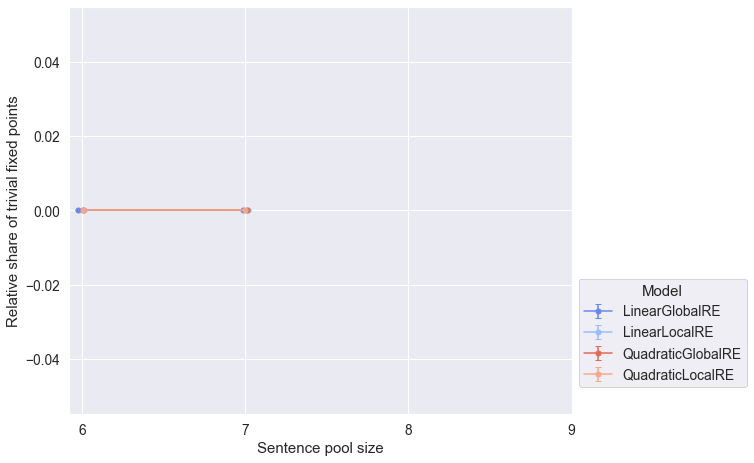

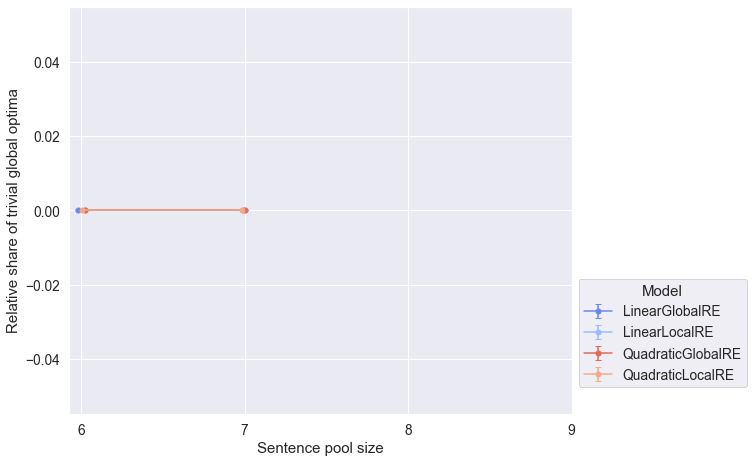

In [35]:
grouping = ['model_name',
            'n_sentence_pool',]

for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ["fp", "go"]):
  
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    
    result_df = rel_share_of_property(df, 
                           "{}_trivial".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if not on_colab:
        file_name = f"rel_{endpoint_type}_trivial_by_sp_{perspective}"
    
    
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_trivial", 
                             ylabel = f"Relative share of trivial {endpoint}",
                             xlabel = "Sentence pool size",
                             var_std=f"std_{endpoint_type}_trivial",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

### Heatmaps

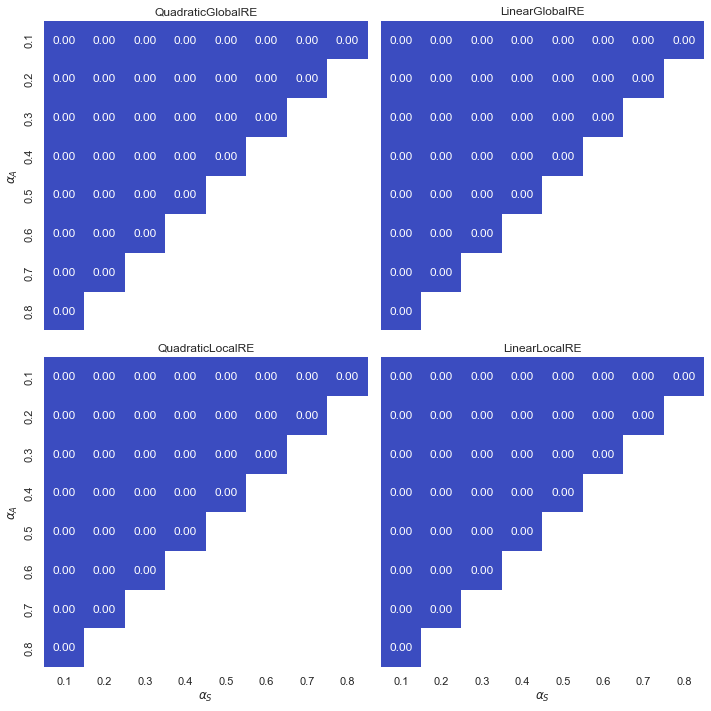

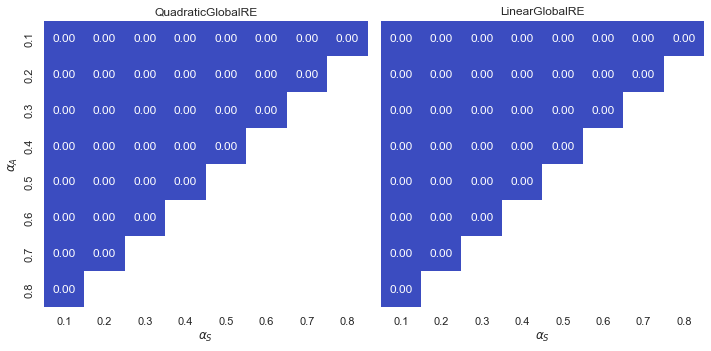

In [36]:
for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ["fp", "go"]):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        df = df[df["model_name"].isin(go_models)]
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"

    heat_maps_by_weights(re_data = df, 
                     values = "{}_trivial".format(endpoint_type), 
                     #title = "Relative share of trivial {}".format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.3f}',
                     vmin=0,
                     vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    

    branches = "pp" if analyse_branches else "rp"

    if not on_colab:
        plt.savefig(path.join(figures_output_dir, 'rel_trivial_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'rel_trivial_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()